<a href="https://colab.research.google.com/github/nw93929/DS4002-CS3/blob/main/CODE/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/jillianhaig/Project2_DS4002 # so we can access data loaded from shared github

Cloning into 'Project2_DS4002'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 254 (delta 48), reused 14 (delta 14), pack-reused 166 (from 1)
Receiving objects: 100% (254/254), 2.93 MiB | 21.11 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
# disable deprecation warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import tests and VAR model from statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# read in data
data = pd.read_csv("/content/Project2_DS4002/DATA/Final Dataset/Hurricane_Dataset.csv", index_col='Year')

# get rid of unneeded columns and take look at data
data = data[data.columns[2:]]
data.head()

,Total_Hurricane_Days,CO2_emissions,Population,CSIRO_Adjusted_SeaLevel_Inch,Surface_Temperature_Change,SurfaceSeaTemp_Annual_Anomaly
Year,,,,,,
1971,67.25,1.550279e+10,3769847834,4.881890,-0.093,-0.519
1972,40.00,1.622344e+10,3844917687,5.240157,-0.199,-0.193
1973,38.50,1.708350e+10,3920805030,5.003937,0.269,-0.151
1974,37.00,1.700938e+10,3996416108,5.472441,-0.181,-0.427
1975,47.25,1.704998e+10,4070735264,5.409449,0.088,-0.445


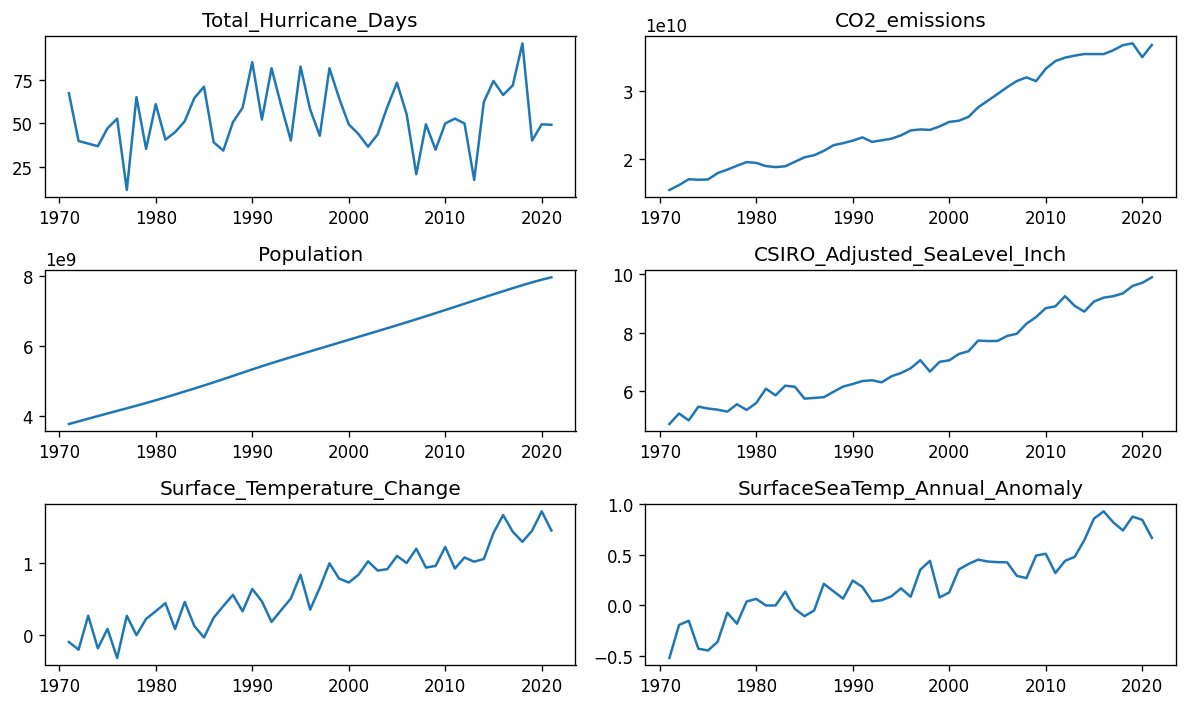

In [ ]:
# set up plot structure
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    temp = data[data.columns[i]]
    ax.plot(temp)
    ax.set_title(data.columns[i])

plt.tight_layout();

We can see many of the series have similar patterns and trends over time, since they seem correlated, we can check for causality among these series using the Granger's Causality test.

In [ ]:
# perform granger's causality test for every combination of relationships
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=12, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(12)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = data.columns)

,Total_Hurricane_Days_x,CO2_emissions_x,Population_x,CSIRO_Adjusted_SeaLevel_Inch_x,Surface_Temperature_Change_x,SurfaceSeaTemp_Annual_Anomaly_x
Total_Hurricane_Days_y,1.0000,0.0244,0.0,0.0000,0.0246,0.0000
CO2_emissions_y,0.0058,1.0000,0.0,0.0003,0.0000,0.0000
Population_y,0.0000,0.0000,1.0,0.0000,0.0000,0.0000
CSIRO_Adjusted_SeaLevel_Inch_y,0.0003,0.0011,0.0,1.0000,0.0008,0.0173
Surface_Temperature_Change_y,0.0404,0.0000,0.0,0.0000,1.0000,0.0000
SurfaceSeaTemp_Annual_Anomaly_y,0.0057,0.0000,0.0,0.0000,0.0000,1.0000


Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero. It essentially tests to see if the past values of the X time series cause the values of the Y time series. If we are able to reject the null hypothesis, it means the coefficients are NOT zero, and that there is indeed a relationship. In our scenario, we see that all the cross relations (the diagonal is its relation with itself so it will always be 1), are significant so we can proceed with our analysis using all variables.

In [ ]:
# cointegration test to test statistically significant relationships
def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Total_Hurricane_Days ::  336.89    > 83.9383   =>   True
CO2_emissions ::  136.04    > 60.0627   =>   True
Population ::  83.27     > 40.1749   =>   True
CSIRO_Adjusted_SeaLevel_Inch ::  49.49     > 24.2761   =>   True
Surface_Temperature_Change ::  26.17     > 12.3212   =>   True
SurfaceSeaTemp_Annual_Anomaly ::  10.57     > 4.1296    =>   True


The Cointegration test sees if a linear combination of some series have an order of integration less than that of the individual series. Essentially it sees if a combination of series converges to stationary faster than the individual series, indicating a statistically significant relationship. It is the basic assumption on which Vector Autoregression(VAR) models are based on. In our scenario we see that all the variables are significant, we can proceed with our analysis with our VAR model assumption met.

In [ ]:
# split into training and testing datasets
nobs = 4 # we are gonna predict 4 time periods ahead (4 months)
data_train, data_test = data[0:-nobs], data[-nobs:]
print(data_train.shape)
print(data_test.shape)

(47, 6)
(4, 6)


In [ ]:
def adf_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# ADF Test on each variable
for name, column in data_train.items():
    adf_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Total_Hurricane_Days" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1822
 No. Lags Chosen       = 0
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO2_emissions" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7495
 No. Lags Chosen       = 0
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.9908. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Population" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [ ]:
# difference series and re-run ADF test since almost none were stationary
data_traind1 = data_train.diff().dropna()
for name, column in data_traind1.items():
    adf_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Total_Hurricane_Days" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2248
 No. Lags Chosen       = 4
 Critical value 1%     = -3.601
 Critical value 5%     = -2.935
 Critical value 10%    = -2.606
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO2_emissions" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1195
 No. Lags Chosen       = 0
 Critical value 1%     = -3.585
 Critical value 5%     = -2.928
 Critical value 10%    = -2.602
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.

All our series are now stationary, meeting our VAR model assumptions! Now we can start fitting models and comparing them using the AIC scores.

In [ ]:
# compare models of increasing lag and compute AIC scores
model = VAR(data_traind1)
for i in range(1,12):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  64.34527874140083
Lag Order = 2
AIC :  63.97265671082543
Lag Order = 3
AIC :  63.832699742286685
Lag Order = 4
AIC :  61.852795034802014
Lag Order = 5
AIC :  60.124752870630104
Lag Order = 6
AIC :  -17.940473885313835
Lag Order = 7
AIC :  -99.09009990883786
Lag Order = 8
AIC :  -107.17766391518896
Lag Order = 9
AIC :  -108.2040859780341
Lag Order = 10
AIC :  -93.43037404830098
Lag Order = 11
AIC :  -102.12975271303502


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
# fit our order 9 VAR model since it had lowest AIC value (at 10 it increases again and then decreases after but we want to avoid fitting higher order models if possible)
model_fitted = model.fit(9)
model_fitted.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/vector_ar/var_model.py:1558: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 25, Oct, 2024
Time:                     22:38:44
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -93.8364
Nobs:                     37.0000    HQIC:                  -103.139
Log likelihood:           2016.77    FPE:                3.24923e-51
AIC:                     -108.204    Det(Omega_mle):     1.37488e-53
--------------------------------------------------------------------
Results for equation Total_Hurricane_Days
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    5.979823              NAN              NAN             NAN
L1.Total_Hurricane_Days                 -0.494207              NAN   

We have our model now, now we must see how well it actually describes the patterns in the data by looking at the residuals. If there is still leftover correlation in the residuals, it means the model does not explain all the patterns in the time series.

In [ ]:
# calculate the durbin watson statistic to check residuals
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(data.columns, out):
    print(adjust(col), ':', round(val, 2))

Total_Hurricane_Days : 1.91
CO2_emissions : 0.9
Population : 1.78
CSIRO_Adjusted_SeaLevel_Inch : 2.39
Surface_Temperature_Change : 1.72
SurfaceSeaTemp_Annual_Anomaly : 1.84


Ideally, we want the statistic to be around 2 as it being closer to 0 or 4 indicates signs of leftover correlation in the residuals. We notice that this is adhered to for the most part except by the CO2_emissions. For the most part we can say the patterns in the data are being described well by the model, so we can continue to move forward and keep the outlier in mind.

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = data_traind1.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_1d')
df_forecast

9


,Total_Hurricane_Days_1d,CO2_emissions_1d,Population_1d,CSIRO_Adjusted_SeaLevel_Inch_1d,Surface_Temperature_Change_1d,SurfaceSeaTemp_Annual_Anomaly_1d
Year,,,,,,
2018,-17.188213,-1.324118e+09,8.391418e+07,0.293039,-0.560269,0.142279
2019,-1.725949,-2.269678e+09,7.905335e+07,0.110971,0.313086,0.376537
2020,35.799349,3.103567e+08,7.595932e+07,-0.635058,0.173984,-0.125854
2021,9.471255,1.659875e+09,7.615320e+07,0.554338,0.006529,-0.244607


In [ ]:
# revert forecasts back to original scale before we differenced to interpret results easier
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(data_traind1, df_forecast)
df_results.loc[:,['Total_Hurricane_Days_forecast','CO2_emissions_forecast','Population_forecast','CSIRO_Adjusted_SeaLevel_Inch_forecast','Surface_Temperature_Change_forecast','SurfaceSeaTemp_Annual_Anomaly_forecast']]

,Total_Hurricane_Days_forecast,CO2_emissions_forecast,Population_forecast,CSIRO_Adjusted_SeaLevel_Inch_forecast,Surface_Temperature_Change_forecast,SurfaceSeaTemp_Annual_Anomaly_forecast
Year,,,,,,
2018,-11.688213,-7.586893e+08,1.709776e+08,0.342283,-0.791269,0.033279
2019,-13.414162,-3.028368e+09,2.500310e+08,0.453254,-0.478183,0.409816
2020,22.385187,-2.718011e+09,3.259903e+08,-0.181804,-0.304199,0.283962
2021,31.856442,-1.058136e+09,4.021435e+08,0.372533,-0.297670,0.039355


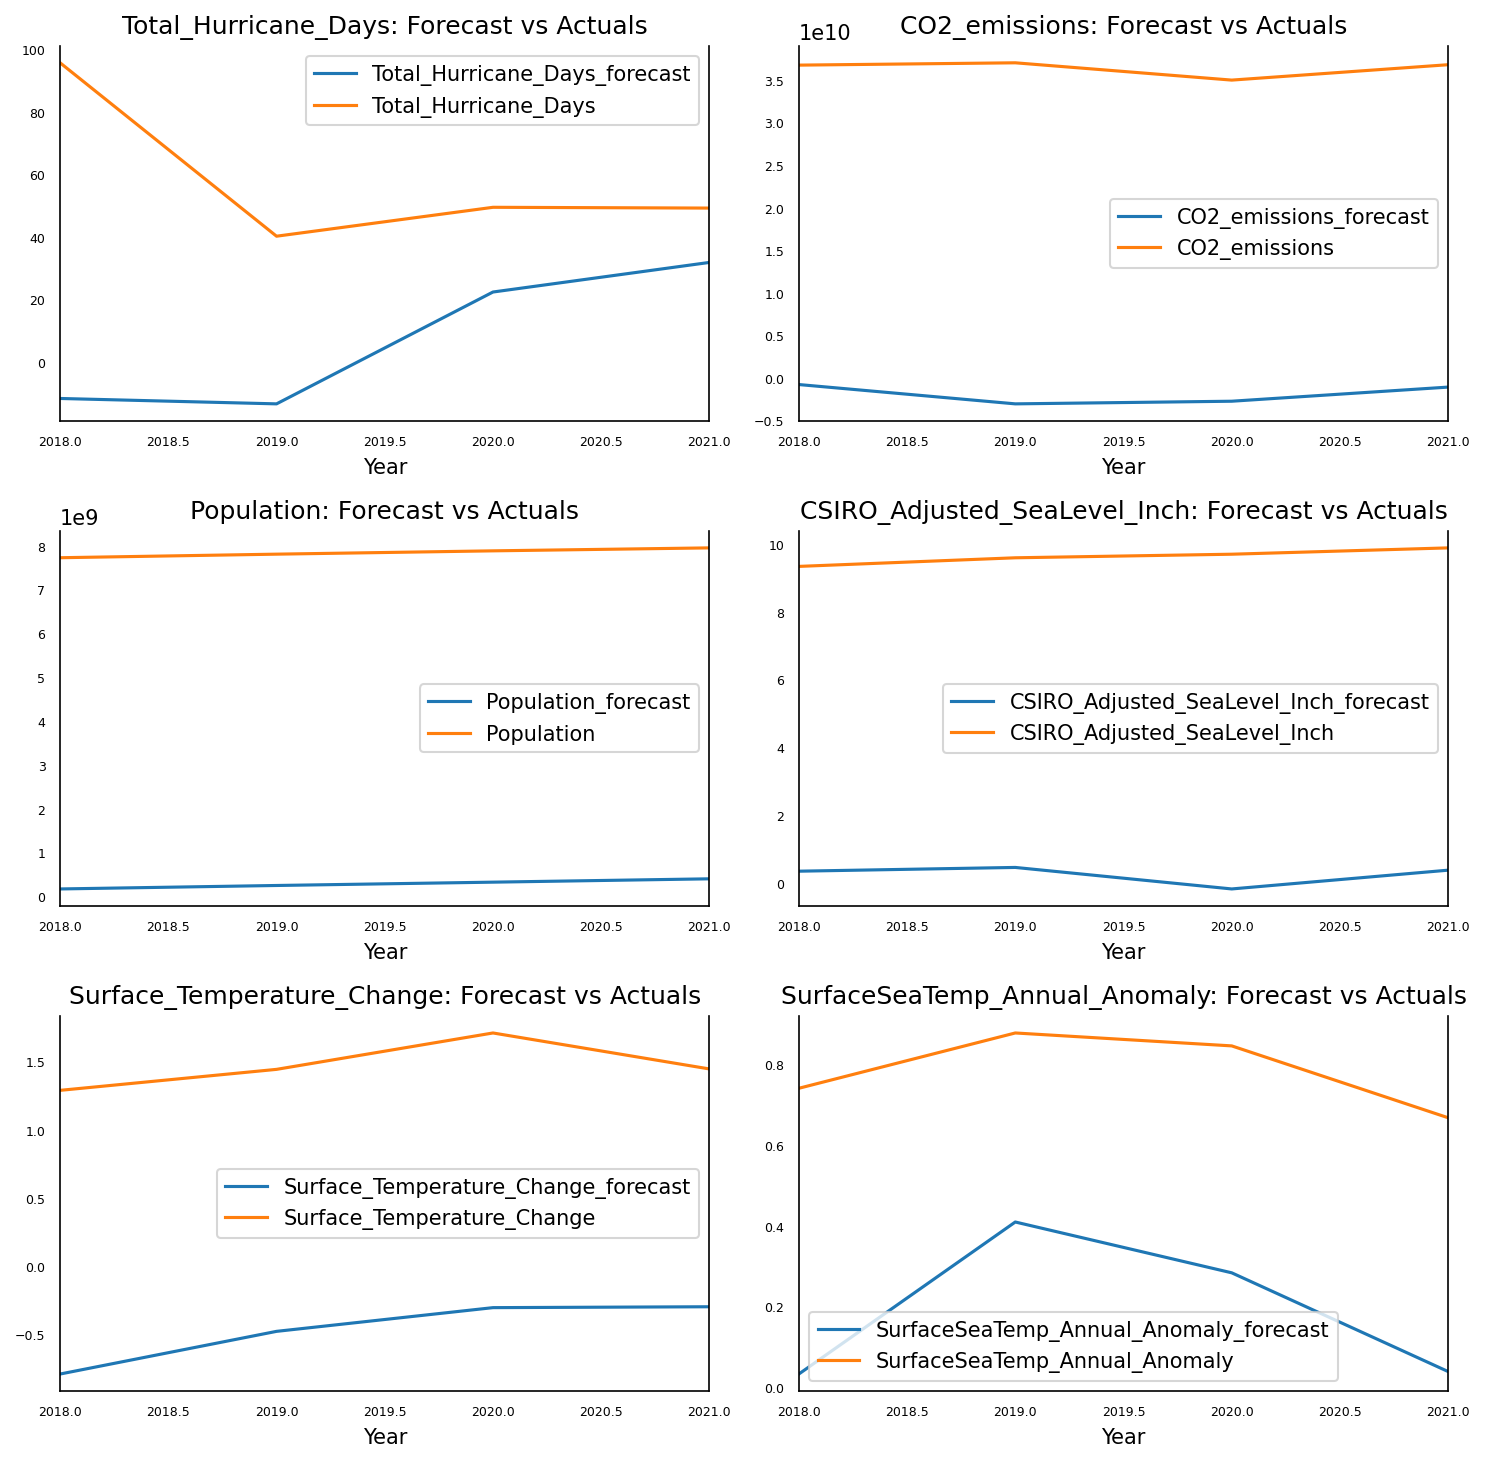

In [ ]:
# plot forecast vs actual
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

We can see that our model did somewhat of a rough job in estimating, it does not seem to be very reliable. Although the pattern is roughly captured the actual numerical values at each time period is significantly smaller than the actual.

In [ ]:
# get some accuracy metrics on the forecast
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'rmse':rmse})

print('Forecast Accuracy of: Total_Hurricane_Days')
accuracy_prod = forecast_accuracy(df_results['Total_Hurricane_Days_forecast'].values, data_test['Total_Hurricane_Days'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Total_Hurricane_Days
rmse   :  62.1703


Considering the RMSE is 62 days, this is not a very good model. So perhaps the relationship is not straight forward enough between these time series to accurately predict hurricane days, however we have confirmed that there is a relationship of some sort through the other tests in previous sections.